In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from scipy.stats import ttest_rel
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import  plot_tree

sys.path.append(os.path.abspath('..'))
from processamento import df, categorical_cols, numeric_cols
from models_training import (
    train_linear_regression,
    train_decision_tree,
    train_svm,
    train_mlp
)

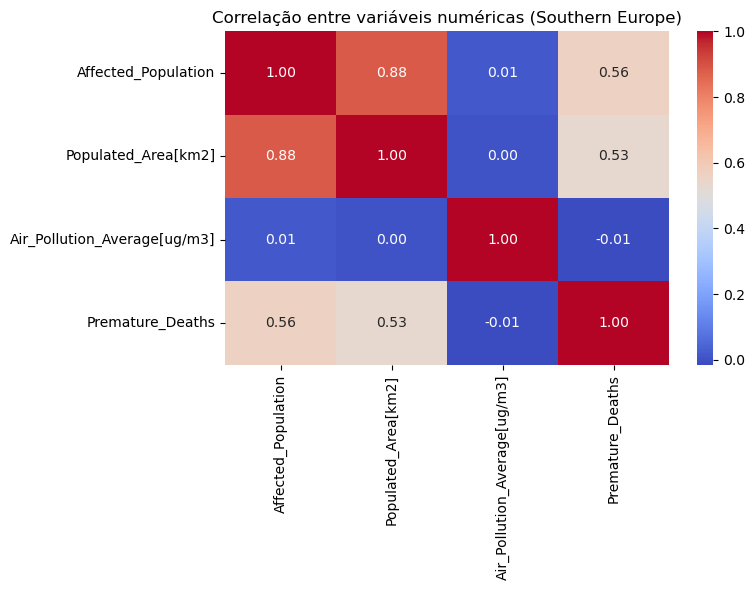

In [ ]:
# Filtrar apenas os dados da Europa do Sul
df_south = df[df['Region'] == 'Southern Europe']

# Selecionar apenas as colunas numéricas + 'Premature_Deaths'
# Correlação de Pearson só é aplicável a variáveis numéricas 
cols_corr = ['Affected_Population', 'Populated_Area[km2]', 'Air_Pollution_Average[ug/m3]', 'Premature_Deaths']
df_corr = df_south[cols_corr]

# Calcular matriz de correlação de Pearson
corr_matrix = df_corr.corr()

# Matriz de correlação
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlação entre variáveis numéricas (Southern Europe)')
plt.tight_layout()
plt.show()

> Como podemos ver, a variável Air_Pollution_Average[ug/m3] não apresenta correlação linear significativa com Premature_Deaths (r ≈ -0.01), o que indica que, pelo menos de forma linear, não contribui para explicar esta variável alvo.

In [ ]:
# Considerar apenas Southern Europe
df_southern = df[df['Region'] == 'Southern Europe']

In [ ]:
# ---------------- Definir o KFold (para todos os modelos) ----------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# Variàvel alvo global
y = df_southern['Premature_Deaths'].values

# **4.2.2 Modelos de regressão linear simples para prever mortes prematuras**

#### Treino do modelo linear com K-Fold Cross Validation e função linear

In [ ]:
# Variável não global de interesse para a regressão linear simples
X = df_southern[['Affected_Population']].values

model = LinearRegression()

mae_scores = []
rmse_scores = []
coefs = []
intercepts = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    
    coefs.append(model.coef_[0])
    intercepts.append(model.intercept_)

print("a) Função linear média resultante:")
print(f"y = {np.mean(coefs):.6f} * X + {np.mean(intercepts):.4f}")

#### Visualização: reta da regressão + diagrama de dispersão

In [ ]:
# Ajustar no conjunto total para visualização
model.fit(X, y)
y_pred_all = model.predict(X)

plt.figure(figsize=(10,6))
plt.scatter(X, y, color='blue', label='Dados reais', alpha=0.6)
plt.plot(X, y_pred_all, color='red', label='Regressão Linear')
plt.xlabel('Affected Population')
plt.ylabel('Premature Deaths')
plt.title('Regressão Linear Simples: Affected Population vs Premature Deaths (Southern Europe)')
plt.legend()
plt.grid(True)
plt.show()

#### Cálculo final de MAE e RMSE médios (validação cruzada)

In [ ]:
print("c) Erro Médio Absoluto (MAE): {:.2f}".format(np.mean(mae_scores)))
print("   Raiz do Erro Quadrático Médio (RMSE): {:.2f}".format(np.mean(rmse_scores)))

# **4.2.3 Desenvolver modelos para prever mortes prematuras**

#### Cálculo do VIF

In [ ]:
# remover a coluna alvo e a coluna com baixa correlação com a variável alvo, respectivamente
X_corr = df_corr.drop(columns=['Premature_Deaths', 'Air_Pollution_Average[ug/m3]'])

# Calcular VIF, sem a coluna 'Air_Pollution_Average[ug/m3]' 
# que tem baixa correlação com a variável alvo
vif_data = pd.DataFrame()
vif_data['feature'] = X_corr.columns
vif_data['VIF'] = [variance_inflation_factor(X_corr.values, i) for i in range(X_corr.shape[1])]

print("\n--- VIF ---")
print(vif_data)

#### Seleção de variáveis para modelos

In [ ]:
# Definir X (features) e y (target)
# dropar a coluna Air_Pollution_Average[ug/m3] pela correlação quase nula com o alvo, 
# e dropar 'Populated_Area[km2]' por ser uma feature redundante (verificar os VIFs)
X = df_southern.drop(columns=['Premature_Deaths', 'Air_Pollution_Average[ug/m3]', 'Populated_Area[km2]'])

# Atualizar numeric_cols para não incluir as colunas removidas
numeric_cols = [col for col in numeric_cols if col in X.columns]

In [ ]:
# ---------------- Preparação dos preprocessadores ----------------
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),    # Normalização das variáveis numéricas
        ('cat', OneHotEncoder(), categorical_cols)  # Codificação one-hot das variáveis categóricas
    ]
)

preprocessor_tree = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_cols)
    ],
    remainder='passthrough'
)

## a) Regressão linear múltipla.

#### Treino do modelo

In [1]:
# ---------------- Regressão Linear Múltipla ----------------
print("\n--- Regressão Linear Múltipla ---")
rmse_scores, mae_scores, r2_scores, pipeline_lr = train_linear_regression(X, y, preprocessor, kf)

print("\n--- Resultados Médios ---")
print(f"RMSE médio : {np.mean(rmse_scores):.2f}")
print(f"MAE médio : {np.mean(mae_scores):.2f}")
print(f"R² médio  : {np.mean(r2_scores):.2f}")


--- Regressão Linear Múltipla ---


NameError: name 'train_linear_regression' is not defined

#### Visualização dos resultados previstos vs os reais

In [ ]:
# Gráfico de Previsões vs Reais
pipeline_lr.fit(X, y)
plt.figure(figsize=(10, 6))
plt.scatter(y, pipeline_lr.predict(X), alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.title('Previsões vs Reais (Regressão Linear Múltipla)')
plt.xlabel('Reais')
plt.ylabel('Previsões')
plt.xlim(y.min(), y.max())
plt.ylim(y.min(), y.max())
plt.grid()
plt.show()

## b) Árvore de regressão com otimização dos parâmetros do modelo

#### Treino do modelo

In [ ]:
print("\n--- Árvore de Decisão ---")
param_grid_tree = {
    'regressor__max_depth': [3, 5, 10, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}
rmse_scores, mae_scores, r2_scores, best_tree, best_params_tree = train_decision_tree(X, y, preprocessor_tree, kf, param_grid_tree)
print("\nMelhores parâmetros encontrados:", best_params_tree)
print("\n--- Resultados Médios ---")
print(f"RMSE médio : {np.mean(rmse_scores):.2f}")
print(f"MAE médio : {np.mean(mae_scores):.2f}")
print(f"R² médio  : {np.mean(r2_scores):.2f}")

#### Visualização: Árvore de Regressão

In [ ]:
best_tree.fit(X, y)
preprocessor_fitted = best_tree.named_steps['preprocessor']
feature_names = preprocessor_fitted.get_feature_names_out()
plt.figure(figsize=(20, 10))
plot_tree(
    best_tree.named_steps['regressor'],
    feature_names=feature_names,
    filled=True,
    rounded=True,
    max_depth=10,
    fontsize=10
)
plt.title("Árvore de Regressão (max_depth=10 para visualização)")
plt.show()

# Gráfico de Previsões vs Reais
plt.figure(figsize=(10, 6))
plt.scatter(y, best_tree.predict(X), alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.title('Previsões vs Reais (Árvore de Decisão)')
plt.xlabel('Reais')
plt.ylabel('Previsões')
plt.xlim(y.min(), y.max())
plt.ylim(y.min(), y.max())
plt.grid()
plt.show()

## c) SVM com otimização do kernel

#### Treino do modelo

In [ ]:
print("\n--- SVM ---")
param_grid_svm = {
    'regressor__kernel': ['linear', 'rbf', 'poly'],
    'regressor__C': [0.1, 1, 10, 100],
    'regressor__gamma': ['scale', 'auto'],
    'regressor__degree': [2, 3, 4]
}
mae_svm, rmse_svm, r2_svm, best_svm, best_params_svm = train_svm(X, y, preprocessor, kf, param_grid_svm)
print("\nMelhores parâmetros do SVM:")
print(best_params_svm)
print("\n--- Resultados Médios ---")
print(f"{'MAE':<10}: {np.mean(mae_svm):.2f}")
print(f"{'RMSE':<10}: {np.mean(rmse_svm):.2f}")
print(f"{'R2':<10}: {np.mean(r2_svm):.2f}")

#### Visualização dos resultados previstos vs os reais

In [ ]:
# Gráfico de Previsões vs Reais
best_svm.fit(X, y)
plt.figure(figsize=(10, 6))
plt.scatter(y, best_svm.predict(X), alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.title('Previsões vs Reais (SVM)')
plt.xlabel('Reais')
plt.ylabel('Previsões')
plt.xlim(y.min(), y.max())
plt.ylim(y.min(), y.max())
plt.grid()
plt.show()

## d) Rede neuronal com otimização da configuração da rede

#### Treino do modelo

In [ ]:
print("\n--- Rede Neuronal ---")
param_grid_mlp = {
    'regressor__hidden_layer_sizes': [(3,), (7,), (10,), (7, 3), (10, 5)],
    'regressor__activation': ['relu', 'tanh'],
    'regressor__solver': ['sgd', 'lbfgs'],
    'regressor__learning_rate_init': [0.001, 0.01]
}
mae_mlp, rmse_mlp, r2_mlp, best_mlp, best_params_mlp = train_mlp(X, y, preprocessor, kf, param_grid_mlp)
print("\nMelhores parâmetros do MLPRegressor:")
print(best_params_mlp)
print("\n--- Resultados Médios ---")
print(f"MAE: {np.mean(mae_mlp):.2f}")
print(f"RMSE: {np.mean(rmse_mlp):.2f}")
print(f"R²: {np.mean(r2_mlp):.3f}")


#### Visualização dos resultados previstos vs os reais

In [ ]:
# Gráfico de Previsões vs Reais
best_mlp.fit(X, y)
plt.figure(figsize=(10, 6))
plt.scatter(y, best_mlp.predict(X), alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.title('Previsões vs Reais (MLPRegressor)')
plt.xlabel('Reais')
plt.ylabel('Previsões')
plt.xlim(y.min(), y.max())
plt.ylim(y.min(), y.max())
plt.grid()
plt.show()

#### Curva de aprendizagem (se possível)

In [ ]:
# Plot loss curve only if solver supports it
if best_params_mlp['regressor__solver'] in ['sgd', 'adam']:
    plt.figure(figsize=(8, 5))
    plt.plot(best_mlp.named_steps['regressor'].loss_curve_)
    plt.title('MLPRegressor Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.show()
else:
    print("Loss curve is not available for solver 'lbfgs'.")

# **Teste dos modelos sem utilização da otimização de parâmetros**

In [ ]:
# ---------------- Testes para Árvore de Decisão ----------------
print("\n--- Árvore de Decisão ---")
# 1
param_grid_tree = {
    'regressor__max_depth': [None],
    'regressor__min_samples_split': [10],
    'regressor__min_samples_leaf': [4]
}
rmse_scores, mae_scores, r2_scores, best_tree, best_params_tree = train_decision_tree(X, y, preprocessor_tree, kf, False, param_grid_tree)
print("\nMelhores parâmetros encontrados:", best_params_tree)
print("\n--- Resultados Médios ---")
print(f"RMSE médio : {np.mean(rmse_scores):.2f}")
print(f"MAE médio : {np.mean(mae_scores):.2f}")
print(f"R² médio  : {np.mean(r2_scores):.2f}")

# 2
param_grid_tree = {
    'regressor__max_depth': [10],
    'regressor__min_samples_split': [10],
    'regressor__min_samples_leaf': [4]
}
rmse_scores, mae_scores, r2_scores, best_tree, best_params_tree = train_decision_tree(X, y, preprocessor_tree, kf, False, param_grid_tree)
print("\nMelhores parâmetros encontrados:", best_params_tree)
print("\n--- Resultados Médios ---")
print(f"RMSE médio : {np.mean(rmse_scores):.2f}")
print(f"MAE médio : {np.mean(mae_scores):.2f}")
print(f"R² médio  : {np.mean(r2_scores):.2f}")

# 3
param_grid_tree = {
    'regressor__max_depth': [10],
    'regressor__min_samples_split': [5],
    'regressor__min_samples_leaf': [4]
}
rmse_scores, mae_scores, r2_scores, best_tree, best_params_tree = train_decision_tree(X, y, preprocessor_tree, kf, False, param_grid_tree)
print("\nMelhores parâmetros encontrados:", best_params_tree)
print("\n--- Resultados Médios ---")
print(f"RMSE médio : {np.mean(rmse_scores):.2f}")
print(f"MAE médio : {np.mean(mae_scores):.2f}")
print(f"R² médio  : {np.mean(r2_scores):.2f}")

In [ ]:
print("\n--- SVM ---")
# 1
param_grid_svm = {
    'regressor__kernel': ['poly'],
    'regressor__C': [100],
    'regressor__gamma': ['scale'],
    'regressor__degree': [4]
}
mae_svm, rmse_svm, r2_svm, best_svm, best_params_svm = train_svm(X, y, preprocessor, kf, False, param_grid_svm)
print("\nMelhores parâmetros do SVM:")
print(best_params_svm)
print("\n--- Resultados Médios ---")
print(f"{'MAE':<10}: {np.mean(mae_svm):.2f}")
print(f"{'RMSE':<10}: {np.mean(rmse_svm):.2f}")
print(f"{'R2':<10}: {np.mean(r2_svm):.2f}")

# 2
param_grid_svm = {
    'regressor__kernel': ['poly'],
    'regressor__C': [50],
    'regressor__gamma': ['auto'],
    'regressor__degree': [4]
}
mae_svm, rmse_svm, r2_svm, best_svm, best_params_svm = train_svm(X, y, preprocessor, kf, False, param_grid_svm)
print("\nMelhores parâmetros do SVM:")
print(best_params_svm)
print("\n--- Resultados Médios ---")
print(f"{'MAE':<10}: {np.mean(mae_svm):.2f}")
print(f"{'RMSE':<10}: {np.mean(rmse_svm):.2f}")
print(f"{'R2':<10}: {np.mean(r2_svm):.2f}")

# 3
param_grid_svm = {
    'regressor__kernel': ['rbf'],
    'regressor__C': [50],
    'regressor__gamma': ['auto'],
    'regressor__degree': [4]
}
mae_svm, rmse_svm, r2_svm, best_svm, best_params_svm = train_svm(X, y, preprocessor, kf, False, param_grid_svm)
print("\nMelhores parâmetros do SVM:")
print(best_params_svm)
print("\n--- Resultados Médios ---")
print(f"{'MAE':<10}: {np.mean(mae_svm):.2f}")
print(f"{'RMSE':<10}: {np.mean(rmse_svm):.2f}")
print(f"{'R2':<10}: {np.mean(r2_svm):.2f}")

# 4
param_grid_svm = {
    'regressor__kernel': ['linear'],
    'regressor__C': [50],
    'regressor__gamma': ['scale'],
    'regressor__degree': [4]
}
mae_svm, rmse_svm, r2_svm, best_svm, best_params_svm = train_svm(X, y, preprocessor, kf, False, param_grid_svm)
print("\nMelhores parâmetros do SVM:")
print(best_params_svm)
print("\n--- Resultados Médios ---")
print(f"{'MAE':<10}: {np.mean(mae_svm):.2f}")
print(f"{'RMSE':<10}: {np.mean(rmse_svm):.2f}")
print(f"{'R2':<10}: {np.mean(r2_svm):.2f}")

In [ ]:
print("\n--- Rede Neuronal ---")
# 1
param_grid_mlp = {
    'regressor__hidden_layer_sizes': [(7,)],
    'regressor__activation': ['tanh'],
    'regressor__solver': ['sgd'],
    'regressor__learning_rate_init': [0.001]
}
mae_mlp, rmse_mlp, r2_mlp, best_mlp, best_params_mlp = train_mlp(X, y, preprocessor, kf, False, param_grid_mlp)
print("\nMelhores parâmetros do MLPRegressor:")
print(best_params_mlp)
print("\n--- Resultados Médios ---")
print(f"MAE: {np.mean(mae_mlp):.2f}")
print(f"RMSE: {np.mean(rmse_mlp):.2f}")
print(f"R²: {np.mean(r2_mlp):.3f}")

# 2
param_grid_mlp = {
    'regressor__hidden_layer_sizes': [(10,)],
    'regressor__activation': ['tanh'],
    'regressor__solver': ['sgd'],
    'regressor__learning_rate_init': [0.001]
}
mae_mlp, rmse_mlp, r2_mlp, best_mlp, best_params_mlp = train_mlp(X, y, preprocessor, kf, False, param_grid_mlp)
print("\nMelhores parâmetros do MLPRegressor:")
print(best_params_mlp)
print("\n--- Resultados Médios ---")
print(f"MAE: {np.mean(mae_mlp):.2f}")
print(f"RMSE: {np.mean(rmse_mlp):.2f}")
print(f"R²: {np.mean(r2_mlp):.3f}")

# 3
param_grid_mlp = {
    'regressor__hidden_layer_sizes': [(7,)],
    'regressor__activation': ['relu'],
    'regressor__solver': ['lbfgs'],
    'regressor__learning_rate_init': [0.001]
}
mae_mlp, rmse_mlp, r2_mlp, best_mlp, best_params_mlp = train_mlp(X, y, preprocessor, kf, False, param_grid_mlp)
print("\nMelhores parâmetros do MLPRegressor:")
print(best_params_mlp)
print("\n--- Resultados Médios ---")
print(f"MAE: {np.mean(mae_mlp):.2f}")
print(f"RMSE: {np.mean(rmse_mlp):.2f}")
print(f"R²: {np.mean(r2_mlp):.3f}")

# **Teste t-student**

**[NOTA]** : No relatório encontram-se as justificações para o teste e os modelos selecionados.
             Os resultados do MAE, MRSE e R2 das alíneas 4.2.3 estão em *'resultados_regressao/'*

> Queremos testar:
> - H₀ (hipótese nula): a média dos MAEs dos dois modelos é igual.
> - H₁ (alternativa): há uma diferença significativa entre os MAEs.

In [ ]:
# Valores extraídos dos ficheiros de resultados
svm_mae = [324.6845, 356.8997, 333.2855, 318.4403, 358.0162]
rt_mae = [387.7154, 409.3296, 402.9762, 396.4452, 410.5294]

t_stat, p_value = ttest_rel(rt_mae, svm_mae)
print(f"t = {t_stat:.3f}, p = {p_value:.4f}")

> Com um valor-p de 0.0002, e assumindo um nível de significância de 5%, rejeita-se a hipótese nula. Concluímos que a diferença entre os modelos SVM e Árvore de Regressão é estatisticamente significativa, com a SVM apresentando um desempenho superior em termos de erro médio absoluto (MAE).